Работу выполнил Данил Исламов (Danil_Islamoff_274397404)

<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Курс "Глубокое обучение". Первый семестр</b></h3>

# Домашнее задание. Сегментация изображений

---


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>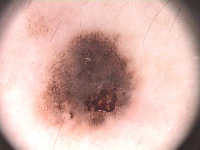</td><td>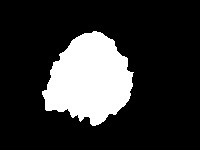</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

--2020-12-21 18:23:22--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2020-12-21 18:23:23--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc13da9b2a570cdf058faee30ea4.dl.dropboxusercontent.com/cd/0/inline/BFjUjVMCL2c4ba4pKMcaja7dKMsIW8ciwAfAnsYdVK9ifOS-ABfBadWfSD4iDhrbbXQcV3Rk-9EXr_aJVQ-aBxi14fGlPiqopMnBt2_oAALFkA/file# [following]
--2020-12-21 18:23:23--  https://uc13da9b2a570cdf058faee30ea4.dl.dropboxusercontent.com/cd/0/inline/BFjUjVMCL2c4ba4pKMcaja7dKMsIW8ciwAfAnsYdVK9ifOS-ABfBadWfSD4iDhrbbXQcV3Rk-9EXr_aJVQ-aBxi14fGlPiqopMnBt2_oAALFkA/file
Resolving 

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

Прим.: SegNet обучалась с batch_size == 10, а оба варианта UNet — с batch_size == 5, т.к. иначе на них память cuda переполнялась

In [ ]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

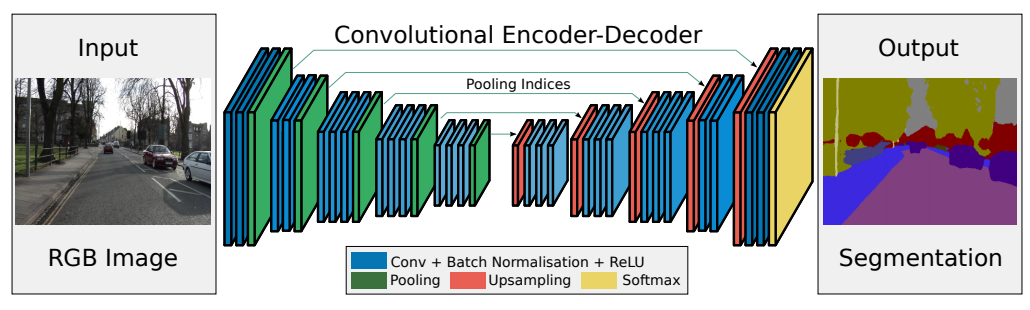

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision import transforms
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1)

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        e0, i0 = self.pool0(self.enc_conv0(x))
        e1, i1 = self.pool1(self.enc_conv1(e0))
        e2, i2 = self.pool2(self.enc_conv2(e1))
        e3, i3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b, i3))
        d1 = self.dec_conv1(self.upsample1(d0, i2))
        d2 = self.dec_conv2(self.upsample2(d1, i1))
        d3 = self.dec_conv3(self.upsample3(d2, i0))  # no activation
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    SMOOTH = 1e-8
    return torch.mean(- y_pred * y_real + torch.log(1 + torch.exp(y_pred)))

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler=None):
    X_val, Y_val = next(iter(data_val))

    loss_tr = []
    loss_val = []
    scores = []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch.to(device))
            loss = loss_fn(Y_batch.to(device), Y_pred) # forward-pass
            loss.backward() # backward-pass
            opt.step() # update weights
            if epoch % 10 == 9 and scheduler:
                scheduler.step()

            # calculate loss to show the user and save
            avg_loss += loss / len(data_tr)
        toc = time()
        
        loss_tr.append(avg_loss)
        
        print('train_loss: %f' % avg_loss)

        # save parameters
        torch.save(model.state_dict(), '/content/drive/MyDrive/DLS_segmentation/current_params.pt')

        # show intermediate results
        model.eval()  # testing mode 
        Y_hat = model(X_val.to(device)).detach().to('cpu') # detach and put into cpu
        cur_loss = loss_fn(Y_val, Y_hat)
        loss_val.append(cur_loss)

        print('val_loss: %f' % cur_loss)

        current_score = score_model(model, iou_pytorch, data_val)
        scores.append(current_score)
        
        print(f"current_score: {current_score}")

        # Visualize tools
        clear_output(wait=True)
        plt.figure(figsize=(18, 9))
        for k in range(5):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Input')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_val[k, 0], cmap='gray')
            plt.title('Ground_truth')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow((nn.Sigmoid()(Y_hat[k, 0]) >= 0.5).float(), cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

    return loss_tr, loss_val, scores

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    outp = [model(X_batch,to(device)) for X_batch, _ in data]
    Y_pred = (nn.Sigmoid()(outp) >= 0.5).float()
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        outp = model(X_batch.to(device))
        Y_pred = (nn.Sigmoid()(outp) >= 0.5).float()
        scores += metric(Y_pred.to(device), Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
model = SegNet().to(device)
max_epochs = 150
opt = optim.AdamW(model.parameters())
tl_Seg_BCE, vl_Seg_BCE, score_Seg_BCE = train(model, opt, bce_loss, max_epochs, data_tr, data_val)

torch.save(model.state_dict(), '/content/drive/MyDrive/DLS_segmentation/Seg_BCE_params.pt')

with open('tl_Seg_BCE.pkl', 'wb') as f:
    pickle.dump(tl_Seg_BCE, f)

with open('vl_Seg_BCE.pkl', 'wb') as f:
    pickle.dump(vl_Seg_BCE, f)

with open('score_Seg_BCE.pkl', 'wb') as f:
    pickle.dump(score_Seg_BCE, f)


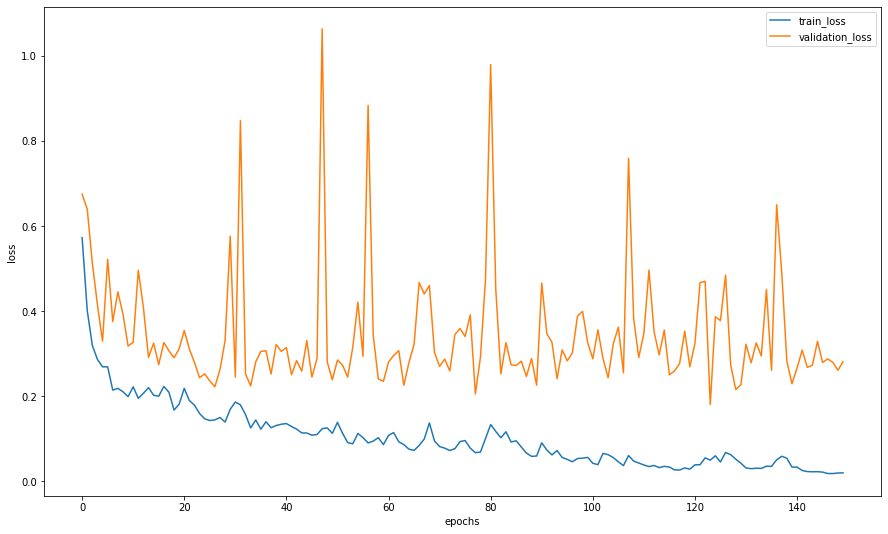

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(tl_Seg_BCE, label="train_loss")
plt.plot(vl_Seg_BCE, label="validation_loss")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

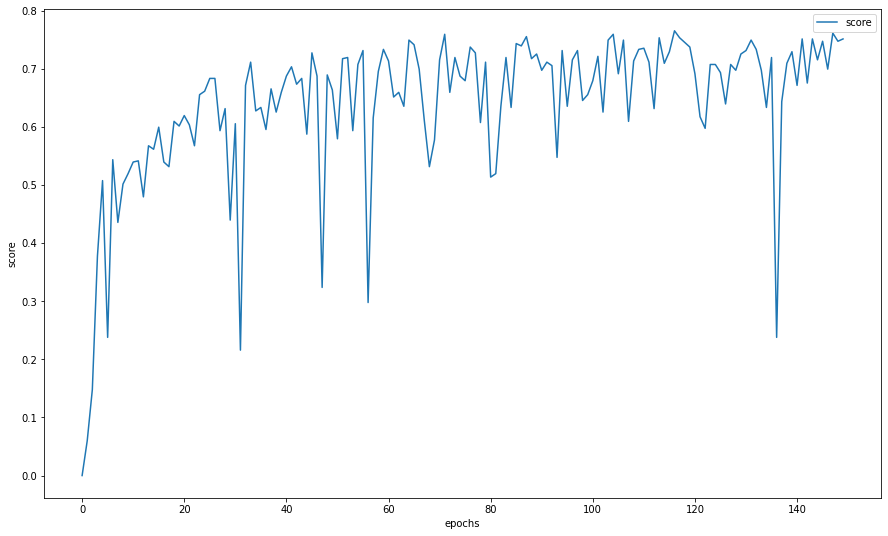

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(score_Seg_BCE, label="score")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
score_model(model, iou_pytorch, data_val)

0.7520000338554382

Несмотря на то, что разница между лоссами на train и validation датасетах с определённого момента начинает увеличиваться — лосс на валидации в среднем почти не меняется, скор растёт на протяжении всего обучения. Поэтому думаю, что, если переобучение и было, то его эффект незначителен

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало, прежде чем бить тревогу попробуйте поперебирать различные варианты, убедитесь, что во всех других сетапах сетть достигает желанного результата. СПОЙЛЕР: учиться она будеет при всех лоссах предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникаемой в математической формуле.


In [ ]:
def dice_loss(y_real, y_pred):
    SMOOTH = 1e-8
    y_pred = nn.Sigmoid()(y_pred)
    num = torch.sum(y_pred * y_real)
    den = torch.sum(y_pred + y_real)
    res = 1 - torch.mean(2 * num / den)
    return res

Проводим тестирование:

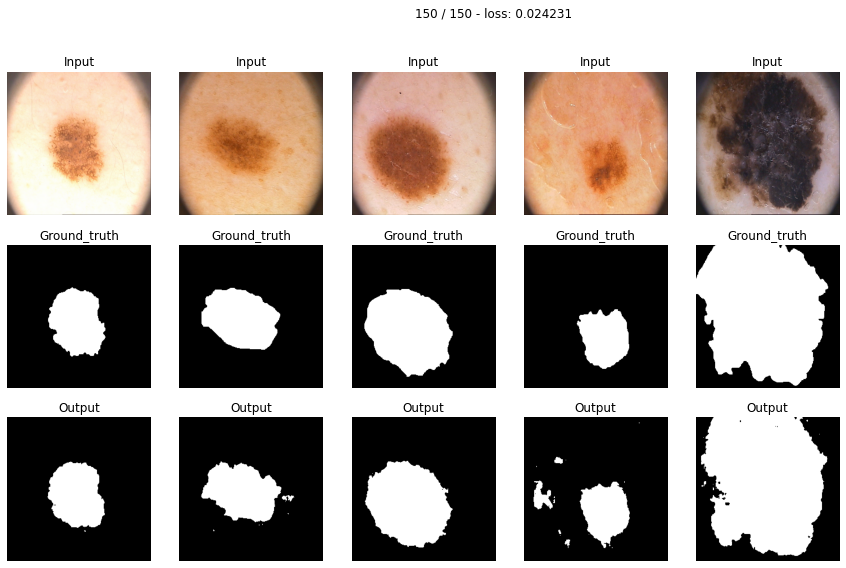

In [ ]:
model = SegNet().to(device)
max_epochs = 150
opt = optim.AdamW(model_dice.parameters())
tl_Seg_dice, vl_Seg_dice, score_Seg_dice = train(model, opt, dice_loss, max_epochs, data_tr, data_val)

torch.save(model.state_dict(), '/content/drive/MyDrive/DLS_segmentation/Seg_dice_params.pt')

with open('tl_Seg_dice.pkl', 'wb') as f:
    pickle.dump(tl_Seg_dice, f)

with open('vl_Seg_dice.pkl', 'wb') as f:
    pickle.dump(vl_Seg_dice, f)

with open('score_Seg_dice.pkl', 'wb') as f:
    pickle.dump(score_Seg_dice, f)

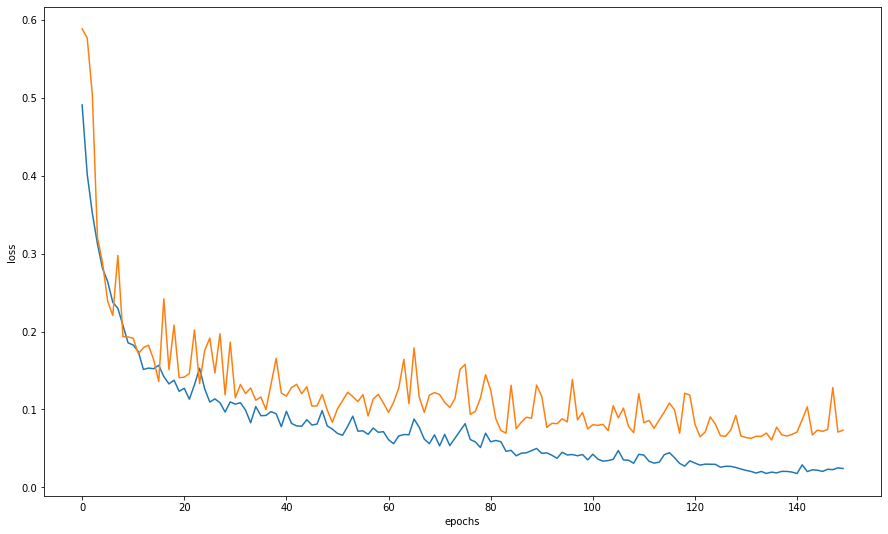

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(tl_Seg_dice, label="train_loss")
plt.plot(vl_Seg_dice, label="validation_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

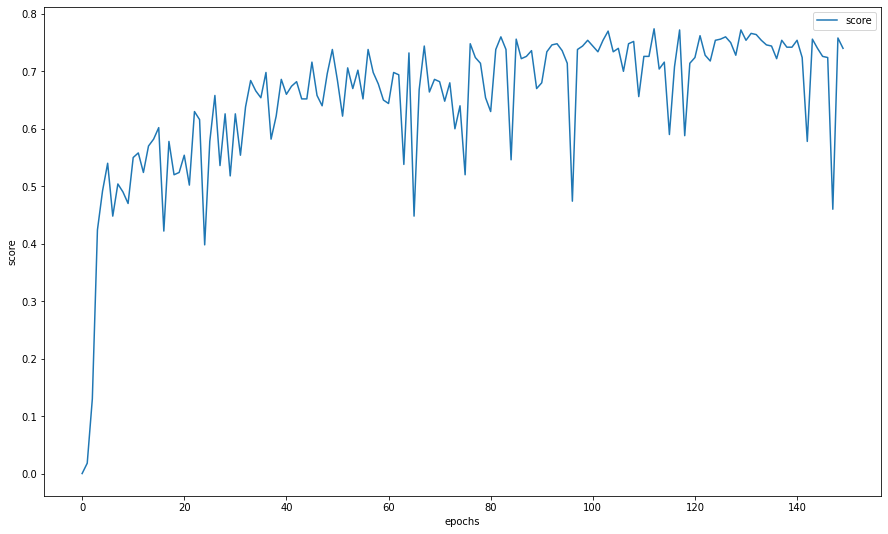

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(score_Seg_dice, label="score")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
score_model(model_dice, iou_pytorch, data_val)

0.7400000095367432

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    SMOOTH = 1e-8
    y_pred = torch.clamp(nn.Sigmoid()(y_pred), 1e-8, 1)
    coef = (1 - y_pred) ** gamma
    return -torch.mean(coef * (y_real) * torch.log(y_pred + SMOOTH) + (1 - y_real) * 
                   torch.log(1 - y_pred + SMOOTH))


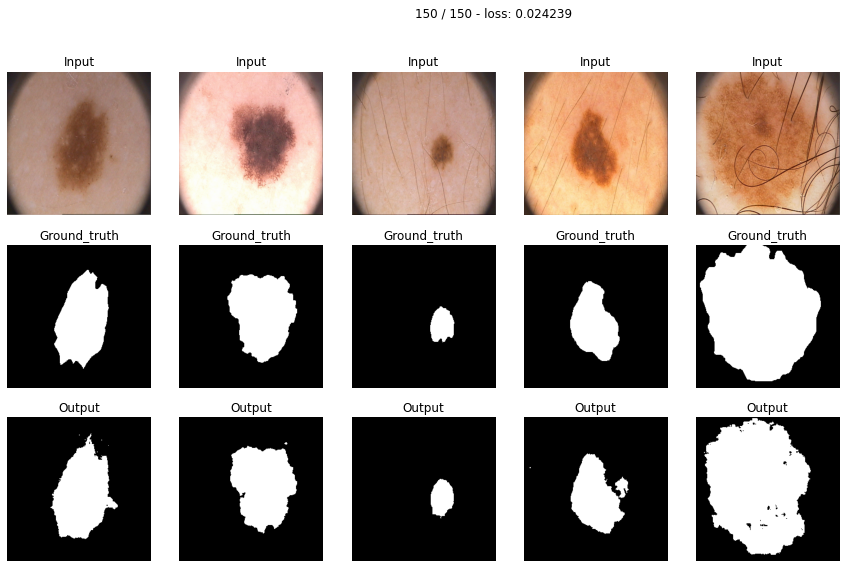

In [ ]:
model = SegNet().to(device)
max_epochs = 150
opt = optim.AdamW(model.parameters())
tl_Seg_focal, vl_Seg_focal, score_Seg_focal = train(model, opt, focal_loss, max_epochs, data_tr, data_val)

torch.save(model.state_dict(), '/content/drive/MyDrive/DLS_segmentation/Seg_focal_params.pt')

with open('tl_Seg_focal.pkl', 'wb') as f:
    pickle.dump(tl_Seg_focal, f)

with open('vl_Seg_focal.pkl', 'wb') as f:
    pickle.dump(vl_Seg_focal, f)

with open('score_Seg_focal.pkl', 'wb') as f:
    pickle.dump(score_Seg_focal, f)

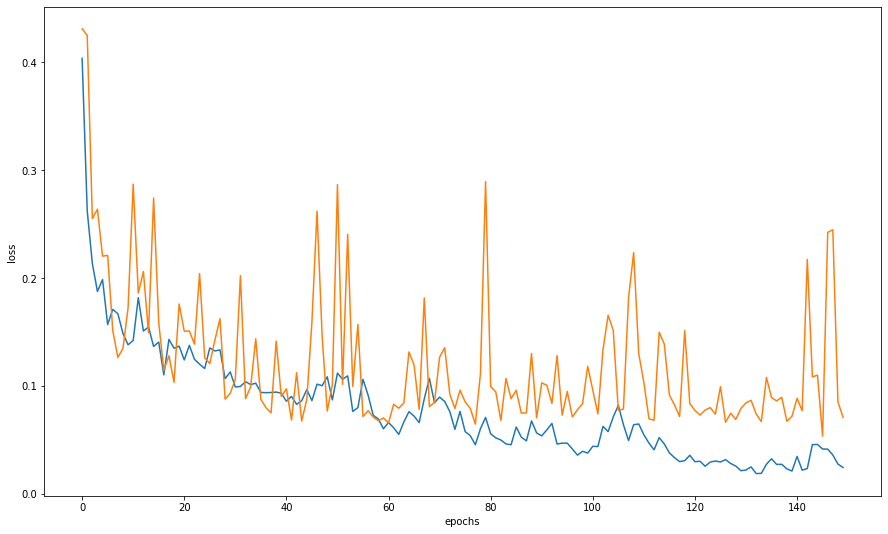

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(tl_Seg_focal, label="train_loss")
plt.plot(vl_Seg_focal, label="validation_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

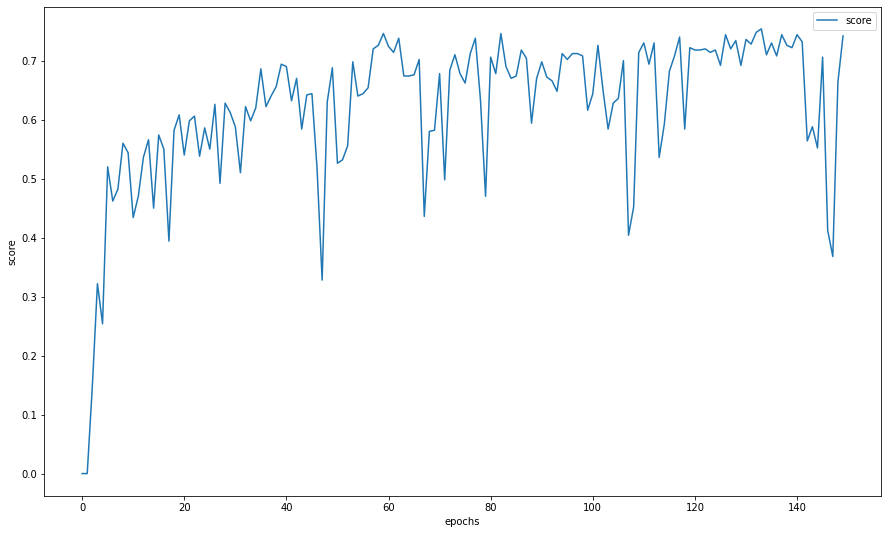

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(score_Seg_focal, label="score")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
score_model(model, iou_pytorch, data_val)

0.7420000314712525

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

Будем реализовывать [Correlation Maximized Structural Similarity Loss](https://arxiv.org/abs/1910.08711)

In [ ]:
def CorMaxSSL_loss(y_real, y_pred, C=0.01, beta=0.1, l=0.5):

    e_max = []
    for i in range(5):
        real_normed = (y_real[i] - torch.mean(y_real[i]) + C) / (torch.std(y_real[i]) + C)
        pred_normed = (y_pred[i] - torch.mean(y_pred[i]) + C) / (torch.std(y_pred[i]) + C)
        e = torch.abs(real_normed - pred_normed)
        e_max.append(torch.max(e).item())
    
    for ind, el in enumerate(e_max):
        e_max[ind] = np.full((1, 256, 256), el)
    
    e_max = torch.from_numpy(np.array(e_max))
    
    indicator = (e.to(device) > beta * e_max.to(device)).float()
    bce = bce_loss(y_real, y_pred)
    ssl = e.to(device) * indicator.to(device) * bce.to(device)

    return torch.mean(l * bce + (1 - l) * ssl)


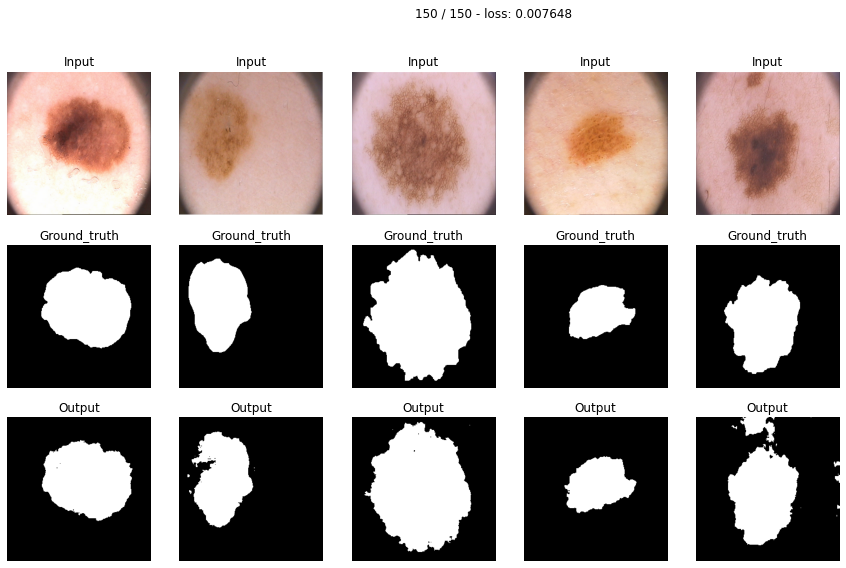

In [ ]:
model = SegNet().to(device)
max_epochs = 150
opt = optim.AdamW(model.parameters())
tl_Seg_SSL, vl_Seg_SSL, score_Seg_SSL = train(model, opt, CorMaxSSL_loss, max_epochs, data_tr, data_val)

torch.save(model.state_dict(), '/content/drive/MyDrive/DLS_segmentation/Seg_SSL_params.pt')

with open('tl_Seg_SSL.pkl', 'wb') as f:
    pickle.dump(tl_Seg_SSL, f)

with open('vl_Seg_SSL.pkl', 'wb') as f:
    pickle.dump(vl_Seg_SSL, f)

with open('score_Seg_SSL.pkl', 'wb') as f:
    pickle.dump(score_Seg_SSL, f)


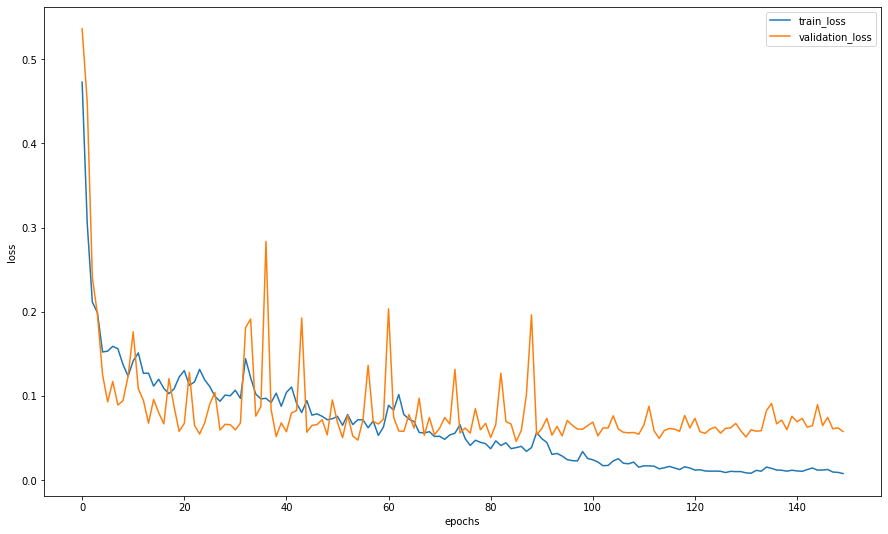

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(tl_Seg_SSL, label="train_loss")
plt.plot(vl_Seg_SSL, label="validation_loss")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

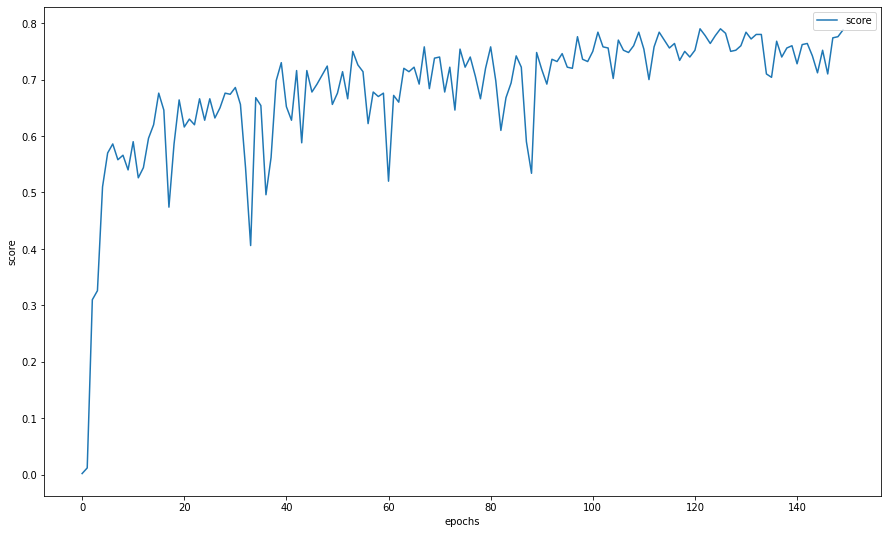

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(score_Seg_SSL, label="score")
plt.legend(loc="best")
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
score_model(model, iou_pytorch, data_val)

0.7880000114440918

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

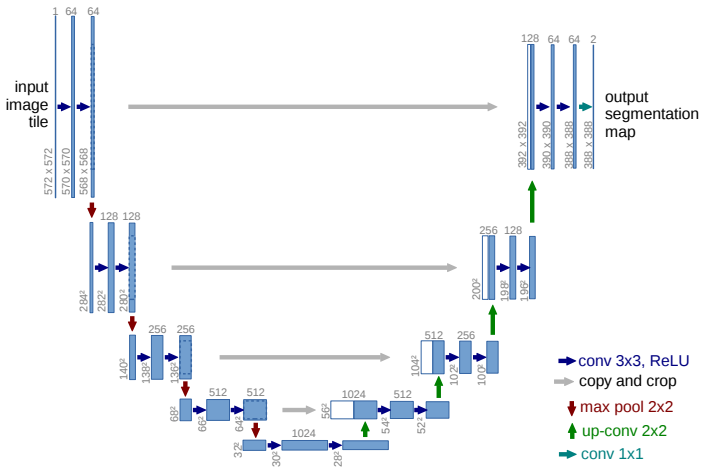

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32
        
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU())

        # decoder (upsampling)
        self.upsample0 = nn.Sequential(
            nn.Upsample(size=32),  # 16 -> 32
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1))
        
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        
        self.upsample1 = nn.Sequential(
            nn.Upsample(size=64),  # 32 -> 64
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1)) 
        
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        
        self.upsample2 = nn.Sequential(
            nn.Upsample(size=128),  # 64 -> 128
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1))
         
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        
        self.upsample3 = nn.Sequential(
            nn.Upsample(size=256),  # 128 -> 256
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1))
        
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1))

    def forward(self, x):
        # encoder
        e00 = self.enc_conv0(x)
        e01 = self.pool0(e00)
        e10 = self.enc_conv1(e01)
        e11 = self.pool1(e10)
        e20 = self.enc_conv2(e11)
        e21 = self.pool2(e20)
        e30 = self.enc_conv3(e21)
        e31 = self.pool3(e30)

        # bottleneck
        b = self.bottleneck_conv(e31)

        # decoder
        d00 = torch.cat((e30, self.upsample0(b)), dim=1)
        d01 = self.dec_conv0(d00)
        d10 = torch.cat((e20, self.upsample1(d01)), dim=1)
        d11 = self.dec_conv1(d10)
        d20 = torch.cat((e10, self.upsample2(d11)), dim=1)
        d21 = self.dec_conv2(d20)
        d30 = torch.cat((e00, self.upsample3(d21)), dim=1)
        d31 = self.dec_conv3(d30) # no activation
        return d31

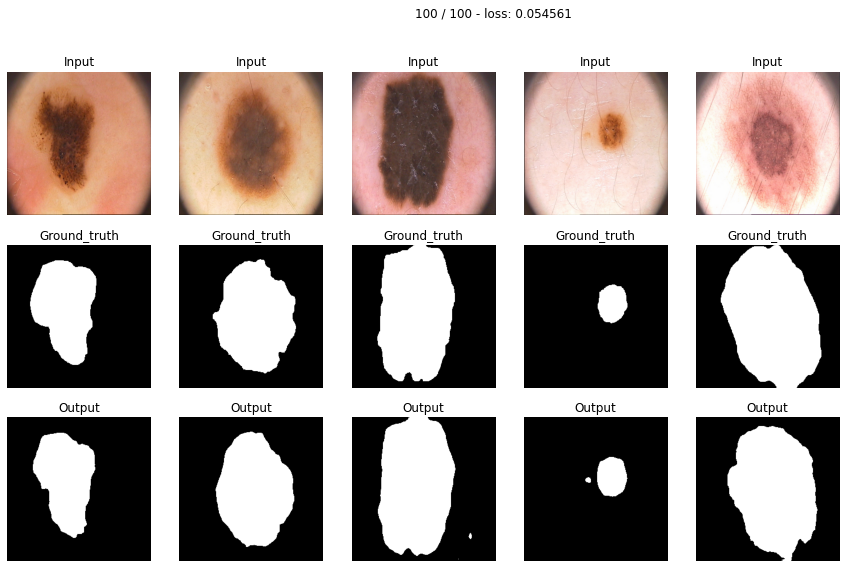

In [ ]:
model = UNet().to(device)
max_epochs = 100
opt = optim.Adam(model.parameters(), 1e-4)
tl_UNet_BCE, vl_UNet_BCE, score_UNet_BCE = \
train(model, opt, bce_loss, max_epochs, data_tr, data_val)

torch.save(model.state_dict(), '/content/drive/MyDrive/DLS_segmentation/UNet_BCE_params.pt')

with open('tl_UNet_BCE.pkl', 'wb') as f:
    pickle.dump(tl_UNet_BCE, f)

with open('vl_UNet_BCE.pkl', 'wb') as f:
    pickle.dump(vl_UNet_BCE, f)

with open('score_UNet_BCE.pkl', 'wb') as f:
    pickle.dump(score_UNet_BCE, f)

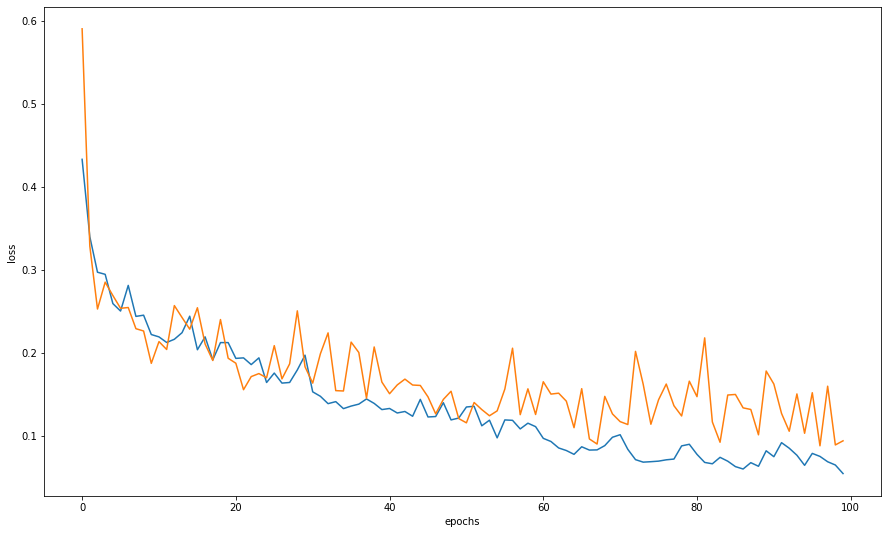

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(tl_UNet_BCE, label="train_loss")
plt.plot(vl_UNet_BCE, label="validation_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

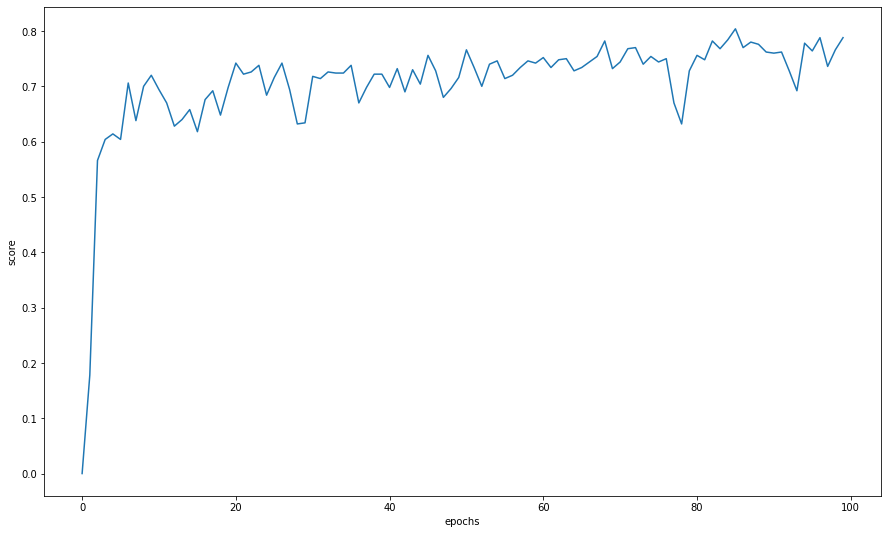

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(score_UNet_BCE, label="score")
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
score_model(model, iou_pytorch, data_val)

0.7880000233650207

UNet dice

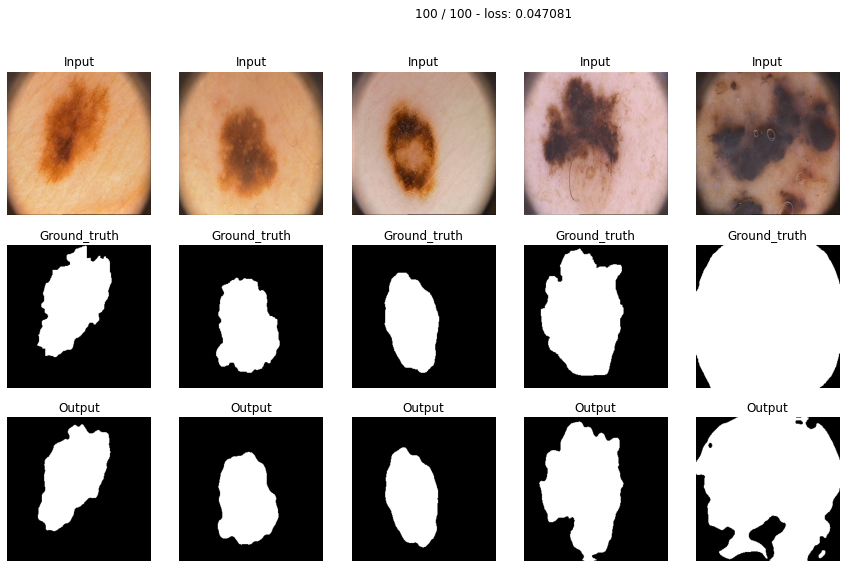

In [ ]:
model = UNet().to(device)
max_epochs = 100
opt = optim.Adam(model.parameters(), 1e-4)
tl_UNet_dice, vl_UNet_dice, score_UNet_dice = train(model, opt, dice_loss, max_epochs, data_tr, data_val)

torch.save(model.state_dict(), '/content/drive/MyDrive/DLS_segmentation/UNet_dice_params.pt')

with open('tl_UNet_dice.pkl', 'wb') as f:
    pickle.dump(tl_UNet_dice, f)

with open('vl_UNet_dice.pkl', 'wb') as f:
    pickle.dump(vl_UNet_dice, f)

with open('score_UNet_dice.pkl', 'wb') as f:
    pickle.dump(score_UNet_dice, f)


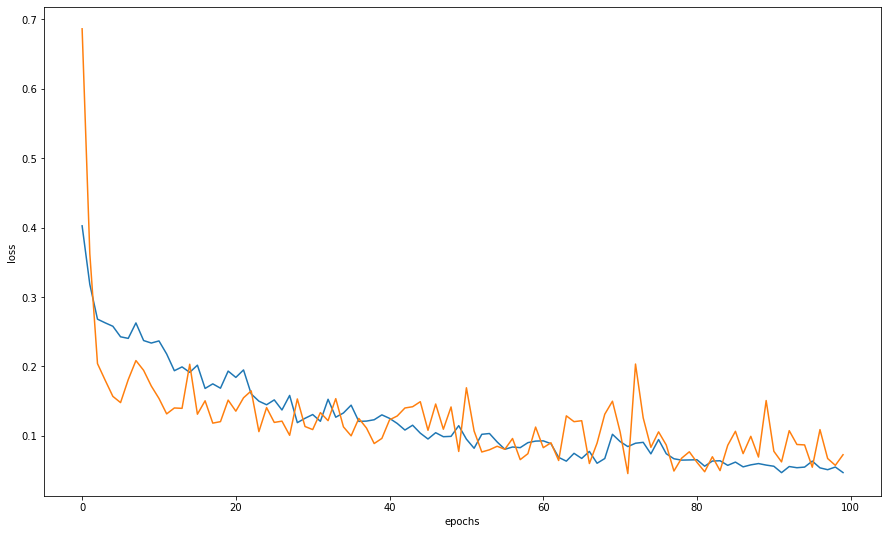

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(tl_UNet_dice, label="train_loss")
plt.plot(vl_UNet_dice, label="validation_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

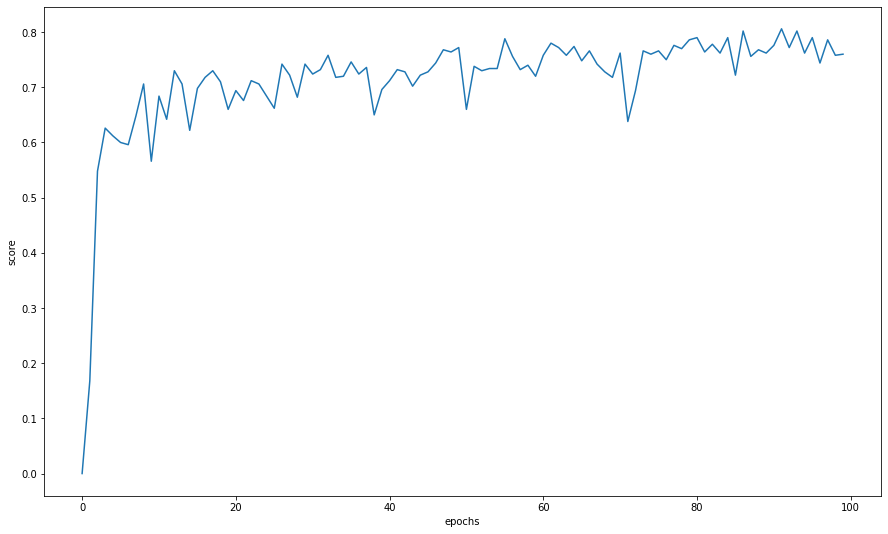

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(score_UNet_dice, label="score")
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
score_model(model, iou_pytorch, data_val)

0.7600000321865081

UNet focal

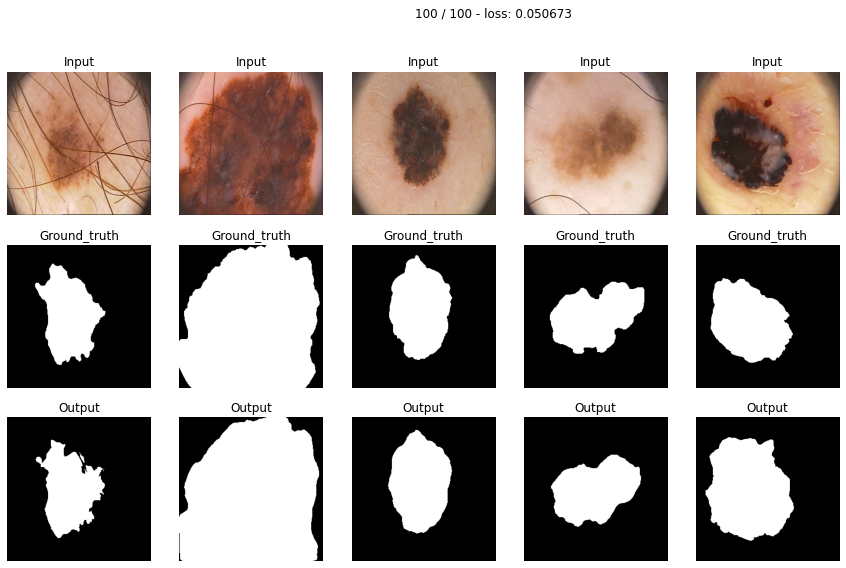

In [ ]:
model = UNet().to(device)
max_epochs = 100
opt = optim.Adam(model.parameters(), 1e-4)
tl_UNet_focal, vl_UNet_focal, score_UNet_focal = train(model, opt, focal_loss, max_epochs, data_tr, data_val)

torch.save(model.state_dict(), '/content/drive/MyDrive/DLS_segmentation/UNet_focal_params.pt')

with open('tl_UNet_focal.pkl', 'wb') as f:
    pickle.dump(tl_UNet_focal, f)

with open('vl_UNet_focal.pkl', 'wb') as f:
    pickle.dump(vl_UNet_focal, f)

with open('score_UNet_focal.pkl', 'wb') as f:
    pickle.dump(score_UNet_focal, f)


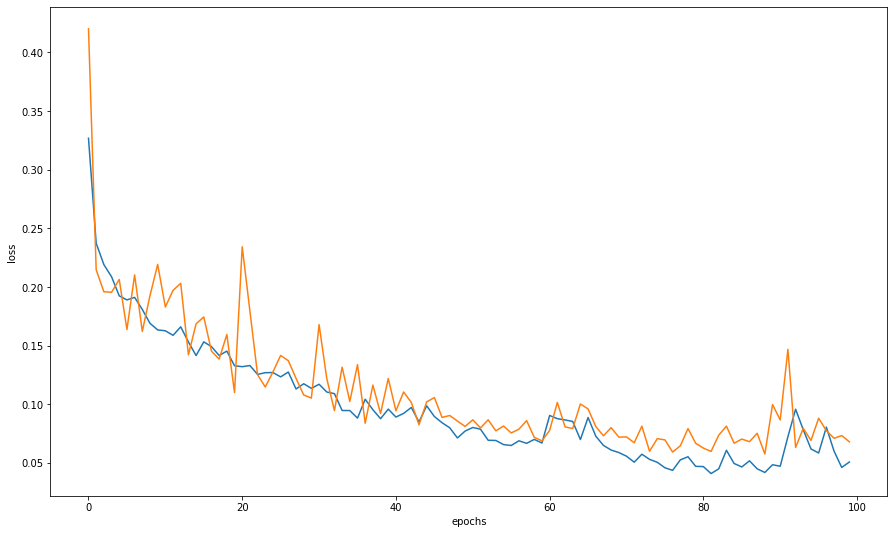

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(tl_UNet_focal, label="train_loss")
plt.plot(vl_UNet_focal, label="validation_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

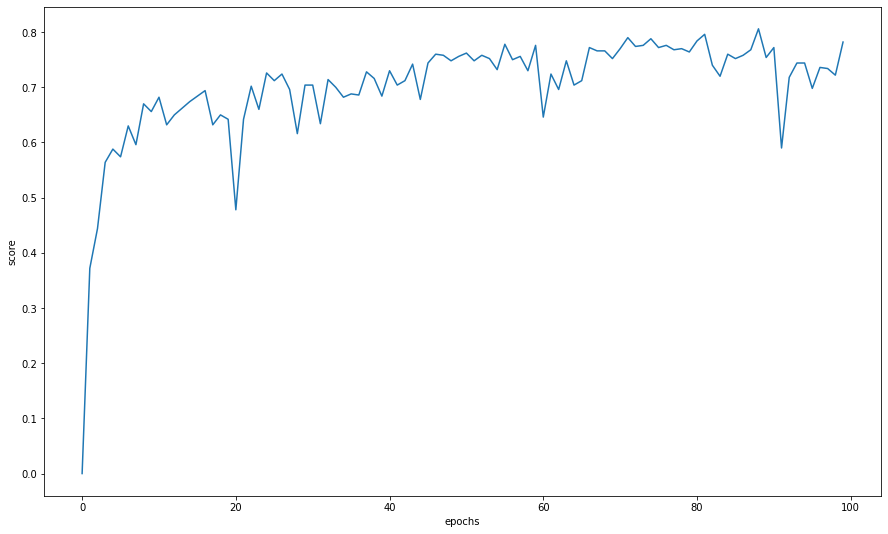

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(score_UNet_focal, label="score")
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
score_model(model, iou_pytorch, data_val)

0.7820000290870667

UNet SSL


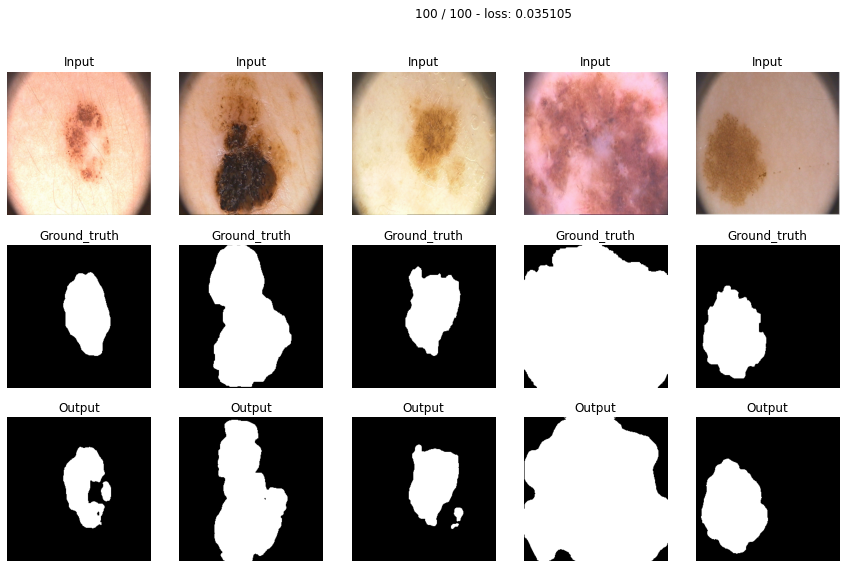

In [ ]:
model = UNet().to(device)
max_epochs = 100
opt = optim.Adam(model.parameters(), 1e-4)
tl_UNet_SSL, vl_UNet_SSL, score_UNet_SSL = train(model, opt, CorMaxSSL_loss, max_epochs, data_tr, data_val)

torch.save(model.state_dict(), '/content/drive/MyDrive/DLS_segmentation/UNet_SSL_params.pt')

with open('tl_UNet_SSL.pkl', 'wb') as f:
    pickle.dump(tl_UNet_SSL, f)

with open('vl_UNet_SSL.pkl', 'wb') as f:
    pickle.dump(vl_UNet_SSL, f)

with open('score_UNet_SSL.pkl', 'wb') as f:
    pickle.dump(score_UNet_SSL, f)


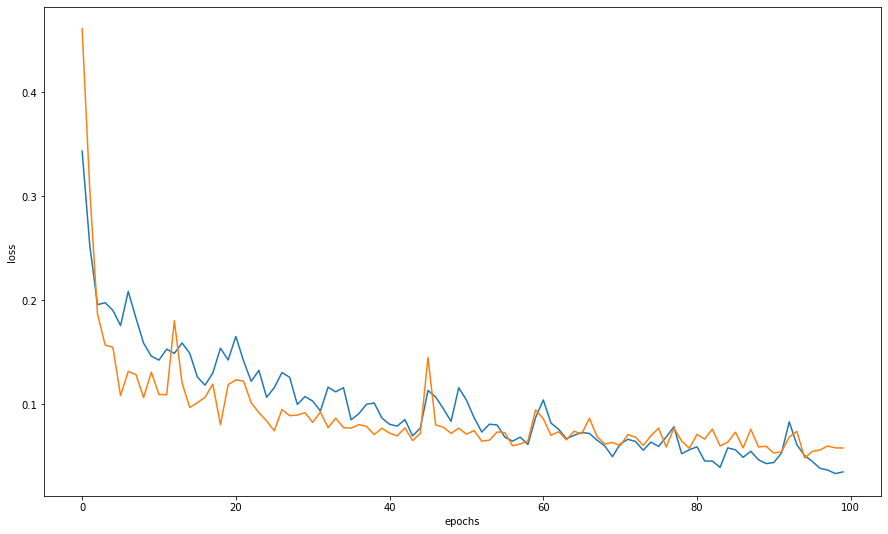

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(tl_UNet_SSL, label="train_loss")
plt.plot(vl_UNet_SSL, label="validation_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

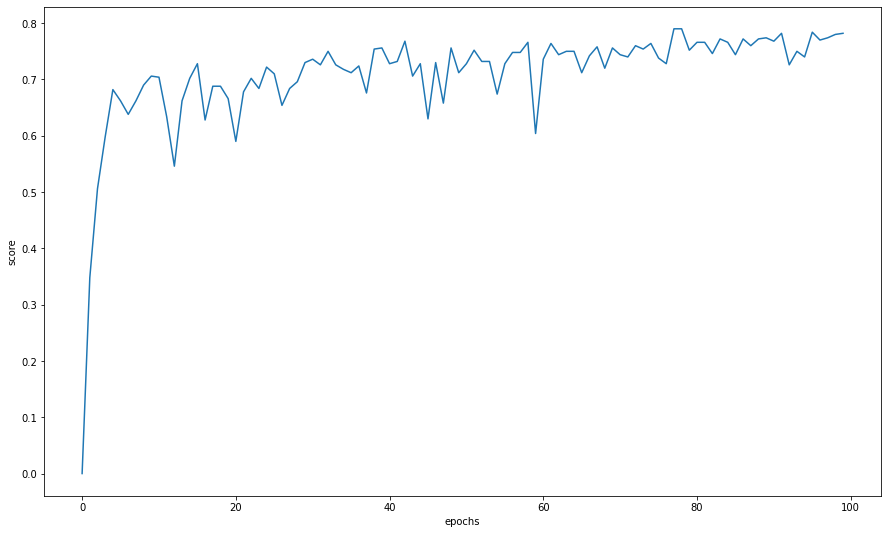

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(score_UNet_SSL, label="score")
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
score_model(model, iou_pytorch, data_val)

0.7820000171661377

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.pool0 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),  # 256 -> 128
            nn.BatchNorm2d(64),
            nn.ReLU()) 
        
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        
        self.pool1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1),  # 128 -> 64
            nn.BatchNorm2d(128),
            nn.ReLU())
        
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        
        self.pool2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1),  # 64 -> 32
            nn.BatchNorm2d(256),
            nn.ReLU())
                
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        
        self.pool3 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1),  # 32 -> 16
            nn.BatchNorm2d(512),
            nn.ReLU())

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU())

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, \
                                            kernel_size=2, stride=2)  # 16 -> 32
        
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        
        self.upsample1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, \
                                            kernel_size=2, stride=2)  # 32 -> 64
        
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        
        self.upsample2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, \
                                            kernel_size=2, stride=2)  # 64 -> 128
         
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        
        self.upsample3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, \
                                            kernel_size=2, stride=2)  # 128 -> 256
        
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1))

    def forward(self, x):
        # encoder
        e00 = self.enc_conv0(x)
        e01 = self.pool0(e00)
        e10 = self.enc_conv1(e01)
        e11 = self.pool1(e10)
        e20 = self.enc_conv2(e11)
        e21 = self.pool2(e20)
        e30 = self.enc_conv3(e21)
        e31 = self.pool3(e30)

        # bottleneck
        b = self.bottleneck_conv(e31)

        # decoder
        d00 = torch.cat((e30, self.upsample0(b)), dim=1)
        d01 = self.dec_conv0(d00)
        d10 = torch.cat((e20, self.upsample1(d01)), dim=1)
        d11 = self.dec_conv1(d10)
        d20 = torch.cat((e10, self.upsample2(d11)), dim=1)
        d21 = self.dec_conv2(d20)
        d30 = torch.cat((e00, self.upsample3(d21)), dim=1)
        d31 = self.dec_conv3(d30) # no activation
        return d31

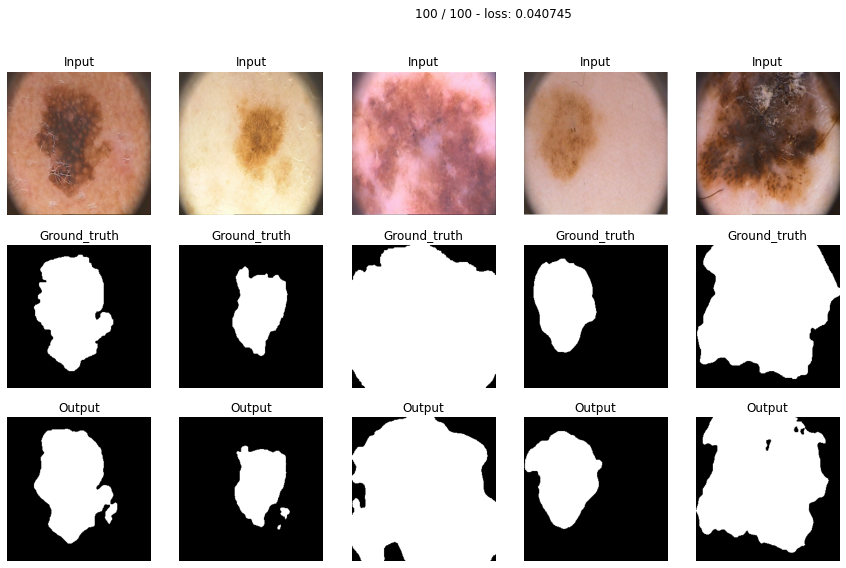

In [ ]:
model = UNet2().to(device)
max_epochs = 100
opt = optim.Adam(model.parameters(), 1e-4)
tl_UNet2_BCE, vl_UNet2_BCE, score_UNet2_BCE = \
train(model, opt, bce_loss, max_epochs, data_tr, data_val)

torch.save(model.state_dict(), '/content/drive/MyDrive/DLS_segmentation/UNet2_BCE_params.pt')

with open('tl_UNet2_BCE.pkl', 'wb') as f:
    pickle.dump(tl_UNet2_BCE, f)

with open('vl_UNet2_BCE.pkl', 'wb') as f:
    pickle.dump(vl_UNet2_BCE, f)

with open('score_UNet2_BCE.pkl', 'wb') as f:
    pickle.dump(score_UNet2_BCE, f)

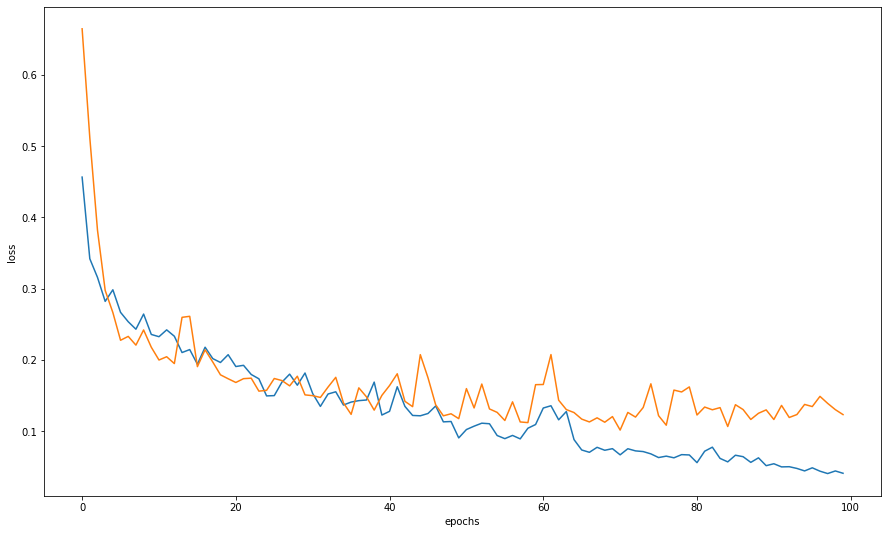

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(tl_UNet2_BCE, label="train_loss")
plt.plot(vl_UNet2_BCE, label="validation_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

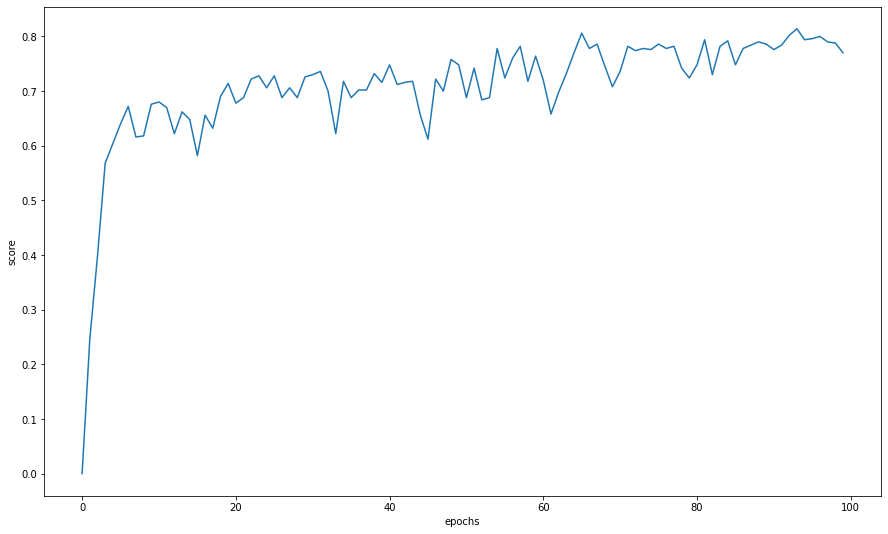

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(score_UNet2_BCE, label="score")
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
score_model(model, iou_pytorch, data_val)

0.7700000405311584

UNet2 dice

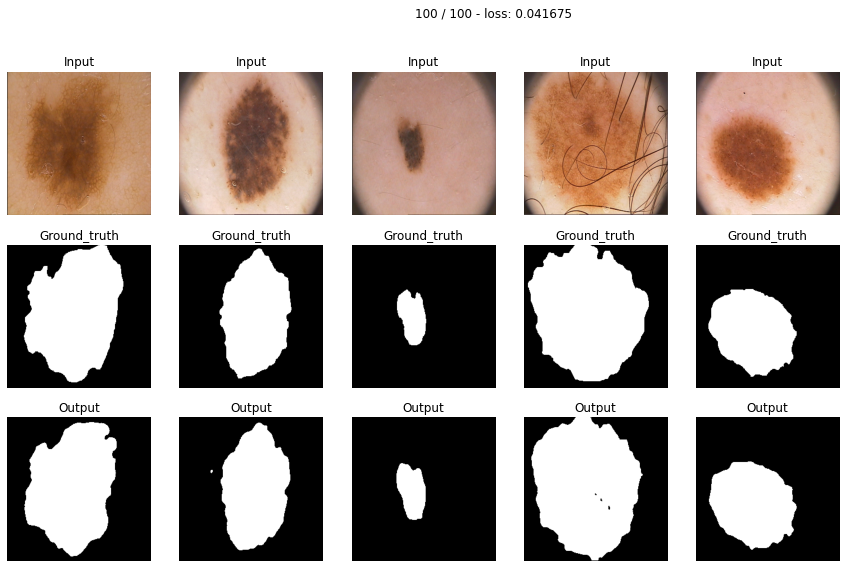

In [ ]:
model = UNet2().to(device)
max_epochs = 100
opt = optim.Adam(model.parameters(), 1e-4)
tl_UNet2_dice, vl_UNet2_dice, score_UNet2_dice = train(model, opt, dice_loss, max_epochs, data_tr, data_val)

torch.save(model.state_dict(), '/content/drive/MyDrive/DLS_segmentation/UNet2_dice_params.pt')

with open('tl_UNet2_dice.pkl', 'wb') as f:
    pickle.dump(tl_UNet2_dice, f)

with open('vl_UNet2_dice.pkl', 'wb') as f:
    pickle.dump(vl_UNet2_dice, f)

with open('score_UNet2_dice.pkl', 'wb') as f:
    pickle.dump(score_UNet2_dice, f)


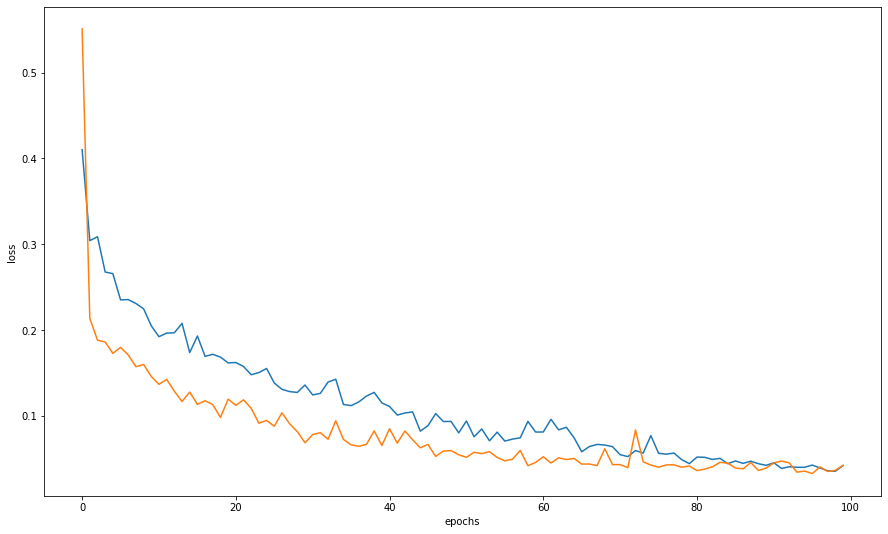

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(tl_UNet2_dice, label="train_loss")
plt.plot(vl_UNet2_dice, label="validation_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

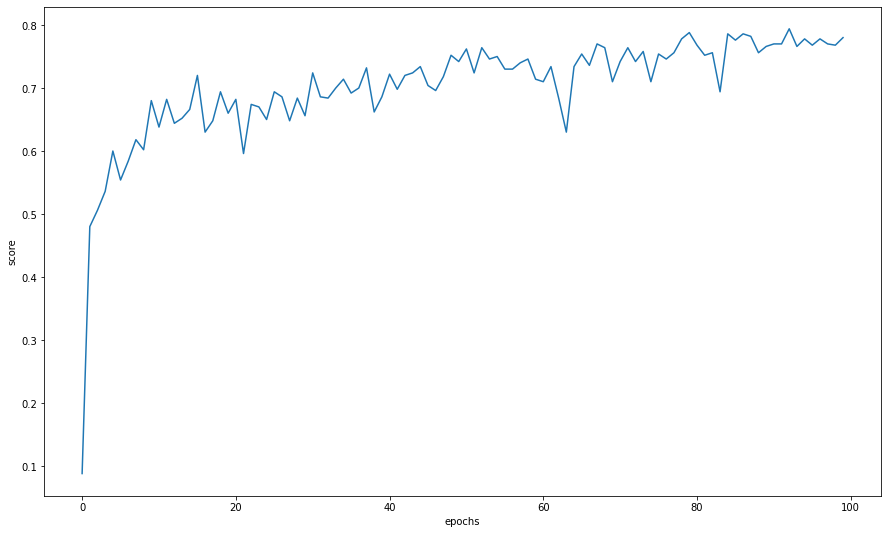

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(score_UNet2_dice, label="score")
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
score_model(model, iou_pytorch, data_val)

0.7800000250339508

UNet2 focal

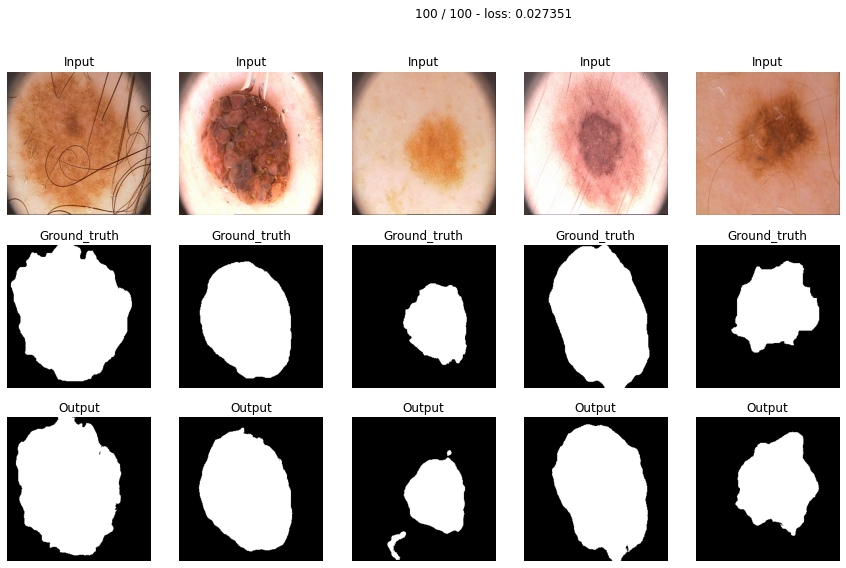

In [ ]:
model = UNet2().to(device)
max_epochs = 100
opt = optim.Adam(model.parameters(), 1e-4)
tl_UNet2_focal, vl_UNet2_focal, score_UNet2_focal = train(model, opt, focal_loss, max_epochs, data_tr, data_val)

torch.save(model.state_dict(), '/content/drive/MyDrive/DLS_segmentation/UNet2_focal_params.pt')

with open('tl_UNet2_focal.pkl', 'wb') as f:
    pickle.dump(tl_UNet2_focal, f)

with open('vl_UNet2_focal.pkl', 'wb') as f:
    pickle.dump(vl_UNet2_focal, f)

with open('score_UNet2_focal.pkl', 'wb') as f:
    pickle.dump(score_UNet2_focal, f)


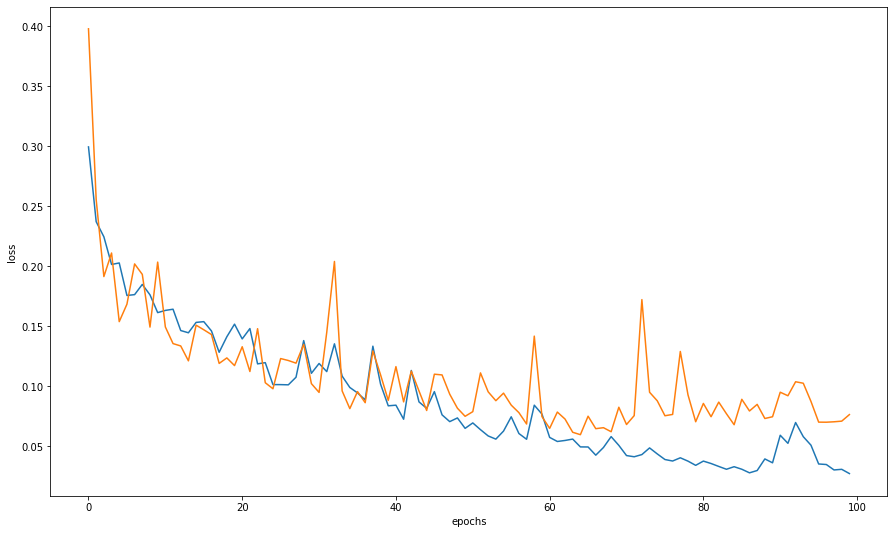

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(tl_UNet2_focal, label="train_loss")
plt.plot(vl_UNet2_focal, label="validation_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

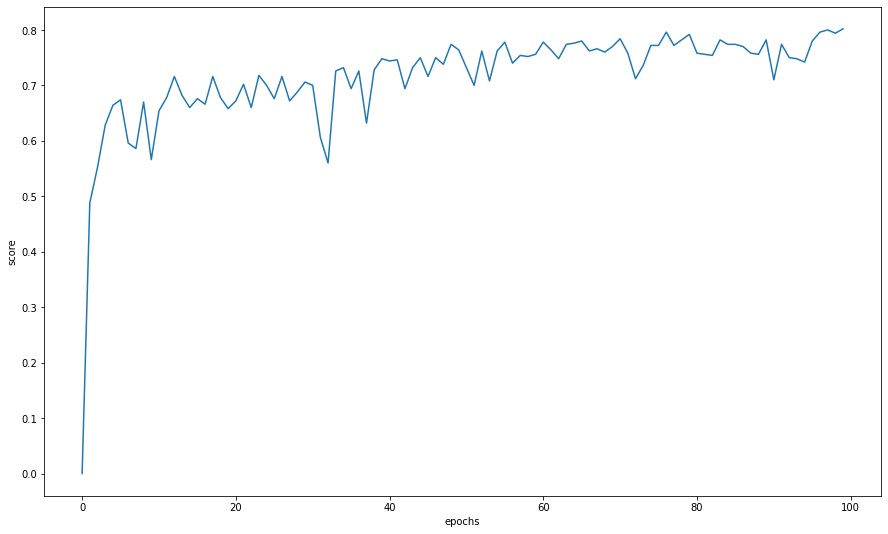

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(score_UNet2_focal, label="score")
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
score_model(model ,iou_pytorch, data_val)

0.8020000338554383

UNet2 SSL

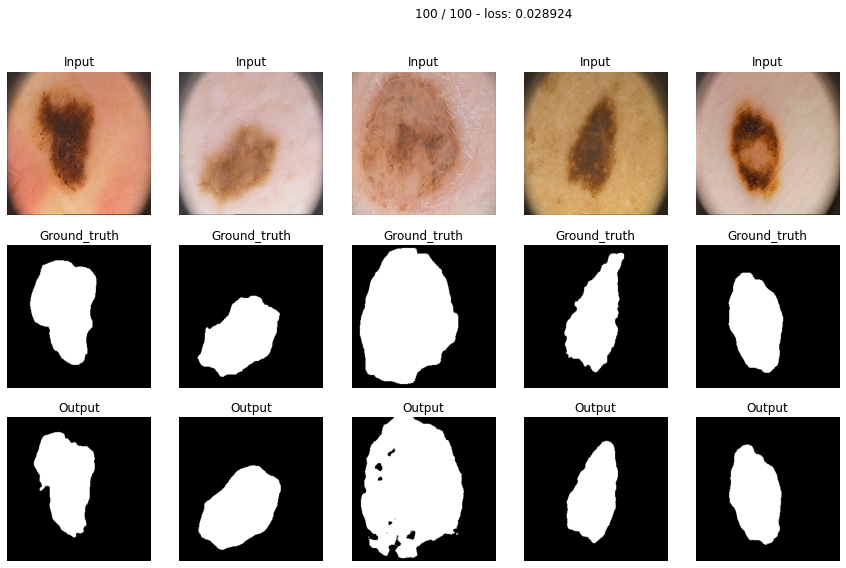

In [ ]:
model = UNet2().to(device)
max_epochs = 100
opt = optim.Adam(model.parameters(), 1e-4)
tl_UNet2_SSL, vl_UNet2_SSL, score_UNet2_SSL = train(model, opt, CorMaxSSL_loss, max_epochs, data_tr, data_val)

torch.save(model.state_dict(), '/content/drive/MyDrive/DLS_segmentation/UNet2_SSL_params.pt')

with open('tl_UNet2_SSL.pkl', 'wb') as f:
    pickle.dump(tl_UNet2_SSL, f)

with open('vl_UNet2_SSL.pkl', 'wb') as f:
    pickle.dump(vl_UNet2_SSL, f)

with open('score_UNet2_SSL.pkl', 'wb') as f:
    pickle.dump(score_UNet2_SSL, f)


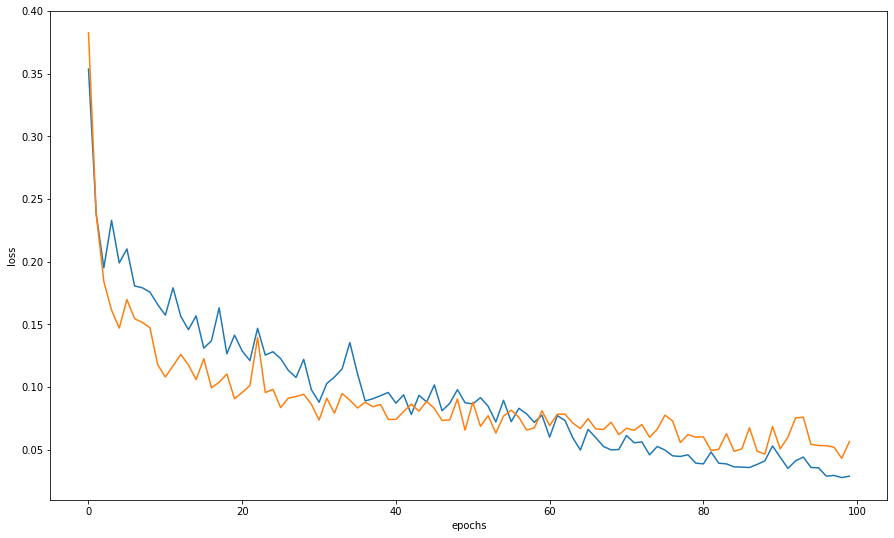

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(tl_UNet2_SSL, label="train_loss")
plt.plot(vl_UNet2_SSL, label="validation_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

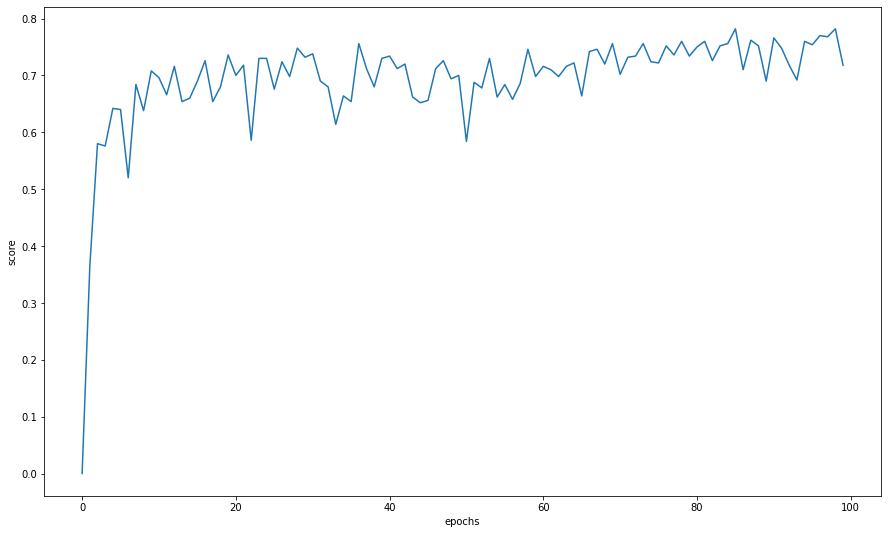

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(score_UNet2_SSL, label="score")
plt.xlabel("epochs")
plt.ylabel("score")
plt.show()

In [ ]:
score_model(model, iou_pytorch, data_val)

0.7180000185966492

Сделайте вывод какая из моделей лучше

# Отчет (6 баллов): 


Проанализируем динамику и скорость сходимости различных лоссов для каждой из моделей 

In [ ]:
models = ['Seg', 'UNet', 'UNet2']
losses = ['BCE', 'dice', 'focal', 'SSL']

l_for_m = {name: {loss: {ds: None for ds in ['tl', 'vl']} for loss in losses} for name in models}

In [ ]:
for name in models:
    for loss in losses:
        with open('_'.join(['tl', name, loss]) + '.pkl', 'rb') as f:
            l_for_m[name][loss]['tl'] = pickle.load(f)
        with open('_'.join(['vl', name, loss]) + '.pkl', 'rb') as f:
            l_for_m[name][loss]['vl'] = pickle.load(f)

In [ ]:
for loss in losses:
    for name in models:
        # Поскольку SegNet обучалась на 150 эпохах, а обе UNet — на 100, возьмём 
        # для сравнения только лоссы на первых 100 эпохах
        if name == 'Seg':
            m_for_l[loss][name] = l_for_m[name][loss]['vl'][:100]
        else:
            m_for_l[loss][name] = l_for_m[name][loss]['vl']

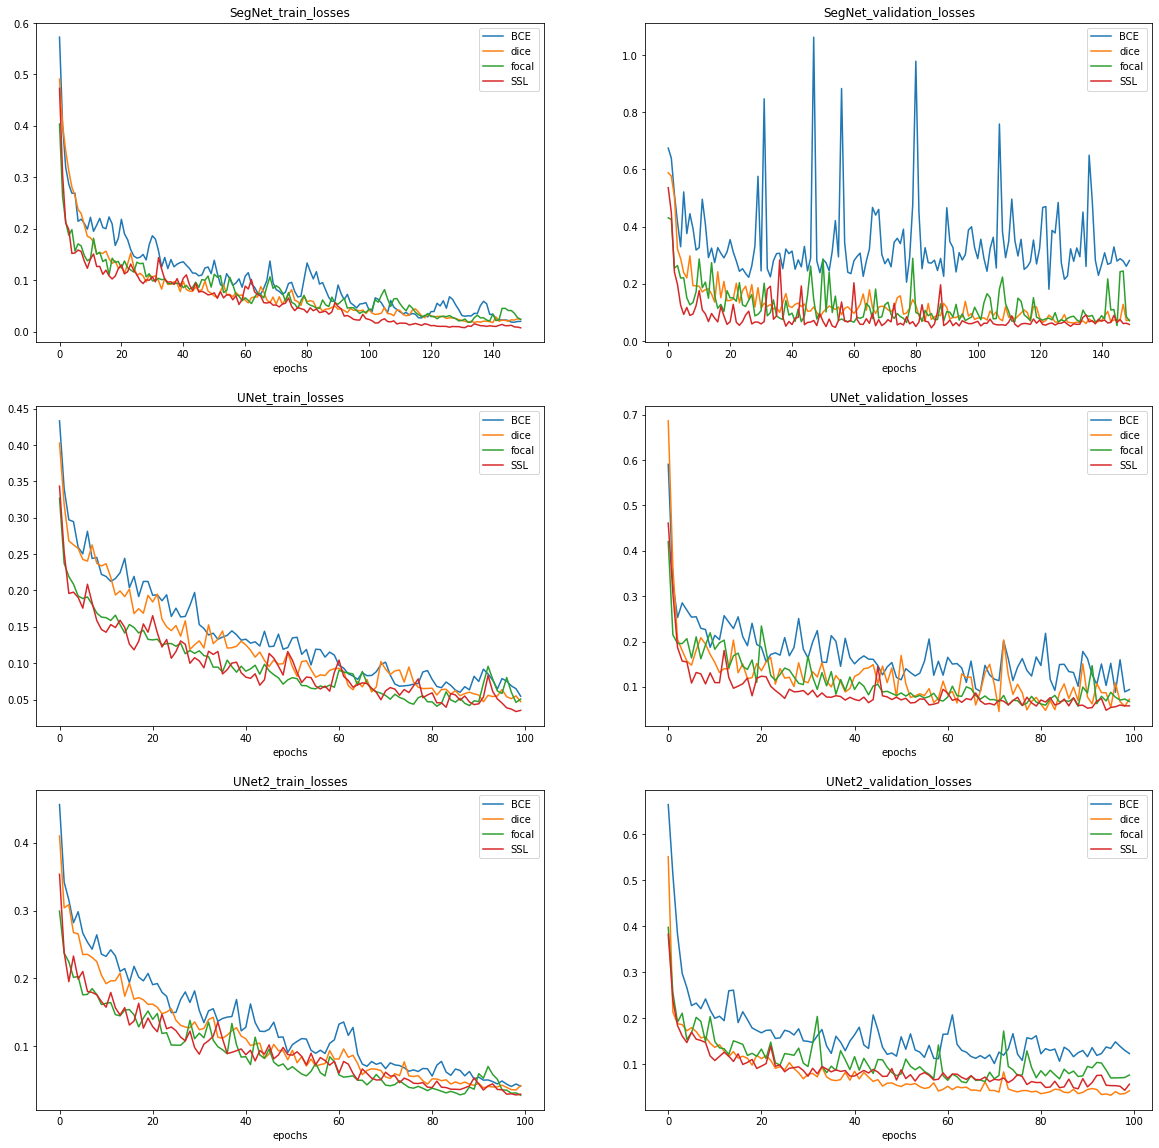

In [ ]:
plt.figure(figsize=(20, 20))
    
plt.subplot(3, 2, 1)
for loss in losses:
    plt.plot(l_for_m['Seg'][loss]['tl'], label=loss)
plt.title('SegNet_train_losses')
plt.xlabel('epochs')
plt.legend()

plt.subplot(3, 2, 2)
for loss in losses:
    plt.plot(l_for_m['Seg'][loss]['vl'], label=loss)
plt.title('SegNet_validation_losses')
plt.xlabel('epochs')
plt.legend()

plt.subplot(3, 2, 3)
for loss in losses:
    plt.plot(l_for_m['UNet'][loss]['tl'], label=loss)
plt.title('UNet_train_losses')
plt.xlabel('epochs')
plt.legend()

plt.subplot(3, 2, 4)
for loss in losses:
    plt.plot(l_for_m['UNet'][loss]['vl'], label=loss)
plt.title('UNet_validation_losses')
plt.xlabel('epochs')
plt.legend()

plt.subplot(3, 2, 5)
for loss in losses:
    plt.plot(l_for_m['UNet2'][loss]['tl'], label=loss)
plt.title('UNet2_train_losses')
plt.xlabel('epochs')
plt.legend()

plt.subplot(3, 2, 6)
for loss in losses:
    plt.plot(l_for_m['UNet2'][loss]['vl'], label=loss)
plt.title('UNet2_validation_losses')
plt.xlabel('epochs')
plt.legend()

None

Разберём по пунктам:



1.   **SegNet**: На графике видно, что на train датасете скорость сходимости dice loss, focal loss и SSL была примерно одинаковой, в то время как BCE loss сходился явно медленнее. 

  На валидации примерно одинаково показали себя dice и focal loss. BCE loss в среднем почти не менялся, оставаясь явно выше остальных трёх лоссов и колеблясь со значительной амплитудой. Structure similarity loss же, на мой взгляд, сошёлся быстрее остальных лоссов.

2.   **UNet**: На train датасете наиболее быстро сходились focal и SS лоссы, медленнее сходился dice, ещё медленнее — BCE.

  На validation датасете dice и focal лоссы показали примерно одинаковую динамику, SSL сошёлся быстрее остальных, BCE loss — медленнее.

3.   **UNet2**: На train датасете картина схожа с таковой у UNet, однако амплитуда колебаний лоссов кажется меньше, при этом значения лоссов к концу обучения оказались значительно более близкими, нежели у предыдущих сетей.

  На валидации лоссы focal, dice и SS сходились примерно с одинаковой скоростью. BCE сходился заметно медленнее


*Выводы*: BCE лосс сходился медленнее остальных и принимал бо́льшие значения для всех моделей. Dice loss, focal loss и SSL показывали довольно близкие результаты и скорость сходимости; на SegNet и UNet наиболее быстро сходился SSL. 



Теперь оценим динамику скоров для каждой из моделей на валидационном датасете

In [ ]:
val_scores_history = {name: {loss: None for loss in losses} for name in models}

for name in models:
    for loss in losses:
        with open('_'.join(['score', name, loss]) + '.pkl', 'rb') as f:
            val_scores_history[name][loss] = pickle.load(f)

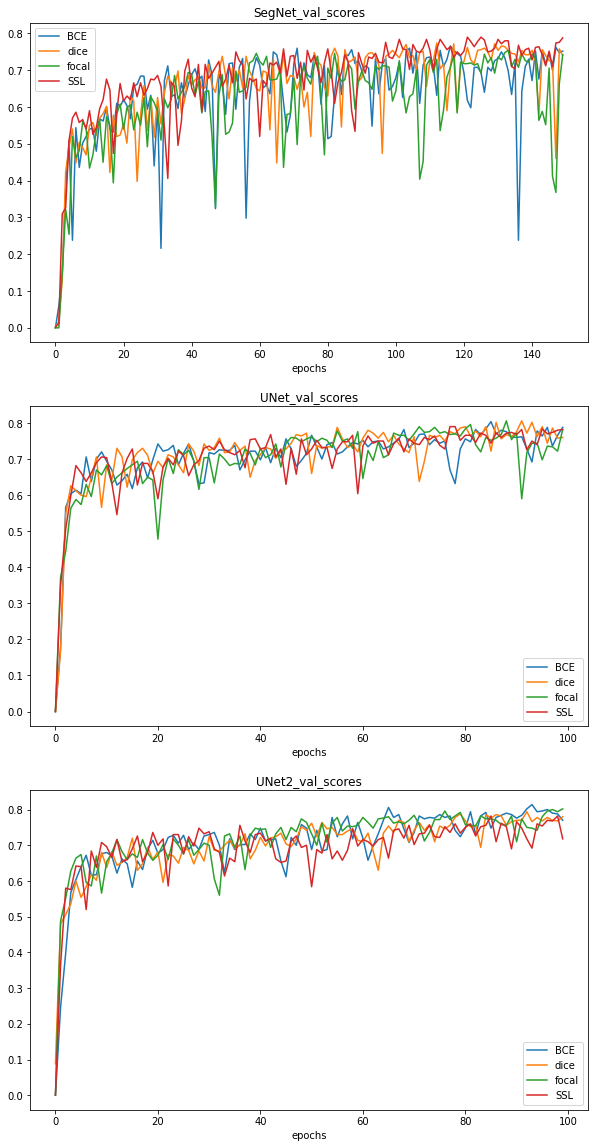

In [ ]:
plt.figure(figsize=(10, 20))
    
plt.subplot(3, 1, 1)
for loss in losses:
    plt.plot(val_scores_history['Seg'][loss], label=loss)
plt.title('SegNet_val_scores')
plt.xlabel('epochs')
plt.legend()

plt.subplot(3, 1, 2)
for loss in losses:
    plt.plot(val_scores_history['UNet'][loss], label=loss)
plt.title('UNet_val_scores')
plt.xlabel('epochs')
plt.legend()

plt.subplot(3, 1, 3)
for loss in losses:
    plt.plot(val_scores_history['UNet2'][loss], label=loss)
plt.title('UNet2_val_scores')
plt.xlabel('epochs')
plt.legend()

None

Для всех моделей скоры получались довольно близкие, выявить какой-то конкретный тренд достаточно сложно, однако, можно уверенно сказать, что скоры SegNet колебались заметно сильнее, чем у обеих версий UNet. Кроме того, скор моделей типа UNet сходился быстрее, чем у SegNet. Замечу также, что при использовании SSL скор SegNet кажется в среднем более высоким. 

Теперь проведём финальную проверку моделей на тестовом датасете

In [ ]:
scores = {name: {loss: None for loss in losses} for name in models}

for name in models:
    for loss in losses:
        if name == 'Seg':
            model = SegNet().to(device)
            model.load_state_dict(torch.load('/content/drive/MyDrive/DLS_segmentation/' + 
                                             '_'.join([name, loss, 'params.pt'])))
            scores[name][loss] = score_model(model, iou_pytorch, data_ts)
        elif name == 'UNet':
            model = UNet().to(device)
            model.load_state_dict(torch.load('/content/drive/MyDrive/DLS_segmentation/' + 
                                             '_'.join([name, loss, 'params.pt'])))
            scores[name][loss] = score_model(model, iou_pytorch, data_ts)
        elif name == 'UNet2':
            model = UNet2().to(device)
            model.load_state_dict(torch.load('/content/drive/MyDrive/DLS_segmentation/' + 
                                             '_'.join([name, loss, 'params.pt'])))
            scores[name][loss] = score_model(model, iou_pytorch, data_ts)

In [ ]:
df = pd.DataFrame(scores)
print(df)
print()
print(df.mean())
print()
print(df.std())

         Seg   UNet  UNet2
BCE    0.858  0.852  0.880
dice   0.818  0.830  0.852
focal  0.818  0.788  0.876
SSL    0.864  0.846  0.820

Seg      0.8395
UNet     0.8290
UNet2    0.8570
dtype: float64

Seg      0.024947
UNet     0.028868
UNet2    0.027592
dtype: float64


На текущей реализации тестового датасета SegNet показала лучший результат с SSL (0.864); UNet — с BCE loss (0.852); UNet2 — с BCE loss (0.880).


Наибольшее среднее значение скора показала UNet2, наименьший разброс — SegNet.

**Итоги**: при заданных выше параметрах модели показали примерно одинаковые результаты, в среднем наилучшее качество показала UNet2. Скоры моделей типа UNet сходились стабильнее и быстрее, чем у SegNet. Касателльно лоссов — медленнее всего у всех моделей сходился BCE, скорость у остальных была примерно одинакова. Хоть это нигде не отражено, однако, модели типа UNet учились значительно дольше SegNet.


**Общий вывод**: считаю, что при заданных параметрах наиболее оптимально использовать SegNet с SSL, т.к. качество моделей отличается незначительно, а обучение SegNet требует гораздо меньше времени. SSL предлагаю использовать потому, что с ним получаются более высокие скоры и более быстрая сходимость SegNet в сравнении с остальными лоссами.